In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import statsmodels.api as sm
from statsmodels.api import OLS
lc_census_merged14 = pd.read_csv('../data/2014_loan_data/pct_accepted_by_zip3_2014_ALL.csv', dtype={'zip_3':str})

# LogReg
all_loans_2014 = pd.read_csv('../hugo/Final_ROI_Model_LogReg_training.csv', dtype={'zip_code':str}, low_memory = False)
all_loans_2015 = pd.read_csv('../hugo/Final_ROI_Model_LogReg_test.csv', dtype={'zip_code':str}, low_memory = False)
all_loans_2014 = all_loans_2014.rename({'zip_code':'ZIP'}, axis='columns')
all_loans_2015 = all_loans_2015.rename({'zip_code':'ZIP'}, axis='columns')
all_loans_2014.ZIP = all_loans_2014.ZIP.str.slice(0,3)
all_loans_2015.ZIP = all_loans_2015.ZIP.str.slice(0,3)

census = pd.read_csv('../data/census_zip3.csv', dtype={'zip_3':str})

all_loans_2014_merged = all_loans_2014.merge(census, "left", left_on="ZIP", right_on="zip_3")
all_loans_2015_merged = all_loans_2015.merge(census, "left", left_on="ZIP", right_on="zip_3")

loans_bought14_temp = all_loans_2014_merged
loans_bought14_temp.loc[:, 'cumsum_amnt'] = loans_bought14_temp.loc[:,'amnt'].cumsum()
loans_bought14_inds = loans_bought14_temp.cumsum_amnt <= 200000000
loans_bought14 = loans_bought14_temp[loans_bought14_inds]
loans_bought15_temp = all_loans_2015_merged
loans_bought15_temp.loc[:, 'cumsum_amnt'] = loans_bought15_temp.loc[:,'amnt'].cumsum()
loans_bought15_inds = loans_bought15_temp.cumsum_amnt <= 200000000
loans_bought15 = loans_bought15_temp[loans_bought15_inds]

loans_bought15 = loans_bought15.merge(lc_census_merged14[['zip_3','pct_accepted']], "left", left_on="ZIP", right_on="zip_3")

num_loans_invested_zip14 = loans_bought14.groupby(['ZIP'])['ZIP'].agg(['count']).reset_index()
num_loans_total_zip14 = all_loans_2014_merged.groupby(['ZIP'])['ZIP'].agg(['count']).reset_index()
loans14 = num_loans_invested_zip14.merge(num_loans_total_zip14, 'left', left_on='ZIP', right_on='ZIP')
loans14.columns = ['ZIP', 'invest', 'total_approved']
loans14['pct_invested'] = loans14.invest/loans14.total_approved
loans_approved_invested14 = loans14.merge(lc_census_merged14, 'left', left_on='ZIP', right_on='zip_3')

As was established in the introduction, we can define discrimination at either the group level or the individual level. In the context of this project, before even debating which one of these approaches might be more justifiable, it will be important to examine what data we have available to us. Below is a brief summary of what characteristics would be legal or moral grounds for claiming discrimination and what characteristics are available to us through the data.

### What variables are there grounds to use for a discrimination argument?
[Legally protected classes](https://www.eeoc.gov/laws/types/):
* Age
* Disability
* Equal Pay/Compensation
* Genetic Information
* Harassment
* National Origin
* Pregnancy
* Race/Color
* Religion
* Retaliation
* Sex
* Sexual Harassment

Characteristics that are protected by being an Equal Housing Lender (which Lending Club is):
* Race
* Color
* Religion
* National origin
* Sex
* Handicap
* Familial status

Other variables research suggests is correlated to socioeconomic status and other important socio-political outcomes:
* Education
* Unemployment
* Poverty
* Income/wealth

### What characteristics are available to us?

Through LendingClub, these characteristics might be valuable to investigate at the individual-level: 
* Income
* Loan description
* Debt-to-income ratio
* Number of mortgage accounts
* Job description

LendingClub provides the first three digits of each approved applicant's zip code. This allows us to get a sense of the demographics of an individual's area from Census data, which we [re-aggregated at the three-digit zip level](https://github.com/bhavenp/209A-FinalProject/blob/master/anthony/census_data_processing.ipynb) after it was provided to us at the five-digit zip level. Thus, we can examine these Census demographics to get at group-level fairness: 
* Race 
    * % of zip code that is nonwhite
* Education
    * % of zip code that holds a Bachelor's degree
* Family status
    * % of zip code that has single parent families
* Gender x age
    * % of zip code that is female age 30-39, for instance
* Unemployment rate
    * % of zip code that is unemployed
* Workforce
    * % of population over 16 years old in the labor force in a zip code
* Household income
    * median income in a zip code

<hr>

Moving forward, our potential options for assessing discrimination are as follows:

| Type | Features |
| --- | --- |
| Individual-level fairness | *Income* |
| Group-level fairness | *Race, family status,<br>education, unemployment* |



For this task, we consider the data available and assert that examining group-level fairness is more justifiable than individual-level fairness. 
1. More information, i.e., Census data, is available at the group-level
2. The data we have at an individual-level that we could use to study discrimination is limited to income, which is not actually a characteristic that can be used to justify individual-level discrimination at this time for this task
3. We find the group-level discrimination argument - that giving more loans to people of historically advantaged racial groups, education brackets, family situations, and employment statuses can ingrain pre-existing hierarchies - more compelling than the individual-level one for the task of investing in a large number of loans across the nation

As such, we will focus on the group-level fairness dimension. Specifically, we will examine 
1. whether Lending Club's process of approving loan applicants is correlated to zip code and, in turn, whether it is correlated to these four demographic characteristics of a zip code,
2. whether our lending strategy that hinges around modeling probability of default to maximize return on investment is discriminatory,
3. and whether we can adjust our modeling or investment strategy to reduce the effects of this discrimination while maintaining a high profit.

## 4.1 Analyzing group-level fairness in the LendingClub process

First, let's take a quick look at the breakdown of Lending Club's loan approval process. It seems that they approve a small fraction of loans from any given zip code with a fairly normal distribution around the center. This should adjust our expectations for future results - even seemingly small changes in loan approval rates by zip code may translate into meaningful real world changes given this scale.

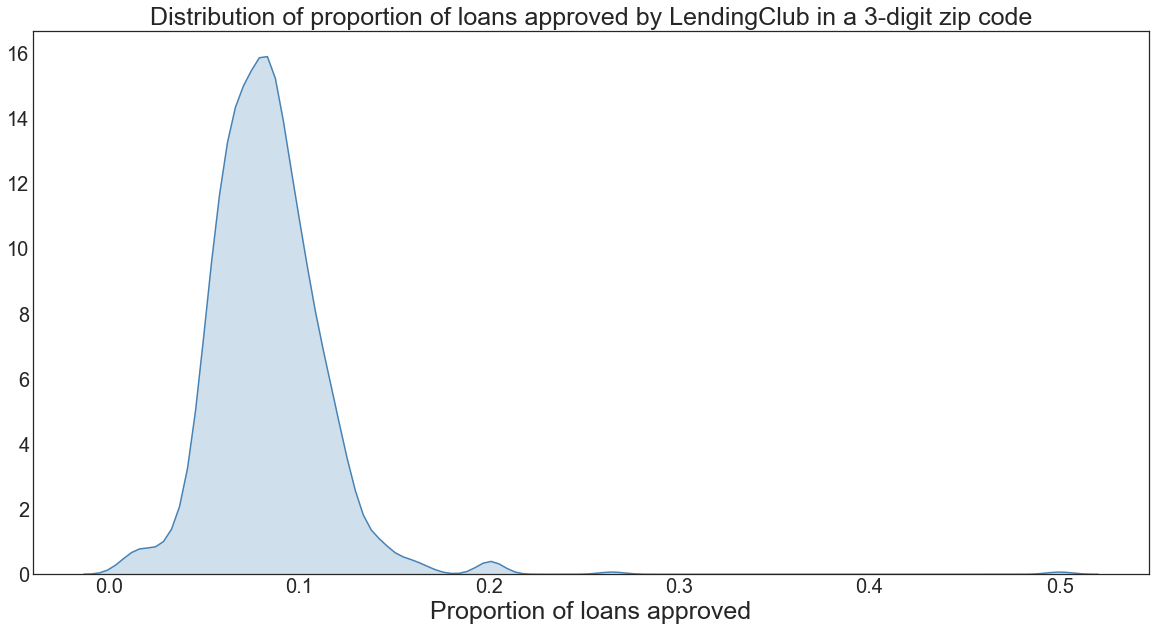

In [2]:
plt.figure(figsize=(20,10))
sns.kdeplot(lc_census_merged14['pct_accepted'].dropna(), shade=True, color='steelblue', legend=False)
plt.xlabel('Proportion of loans approved', fontsize=25)
plt.title('Distribution of proportion of loans approved by LendingClub in a 3-digit zip code', fontsize=25)
plt.tick_params(labelsize=20)
plt.show()

Next we take a look at the relationship between different demographic characteristics and loan approval rates by zip code. It looks like there is a pretty clear trend for education - more highly educated areas have higher loan approval rates. There are slighlty negative correlations for unemployment rate and single parent family composition and there is no discernible trend for race. This should give us another set of expectations for the analysis to come.

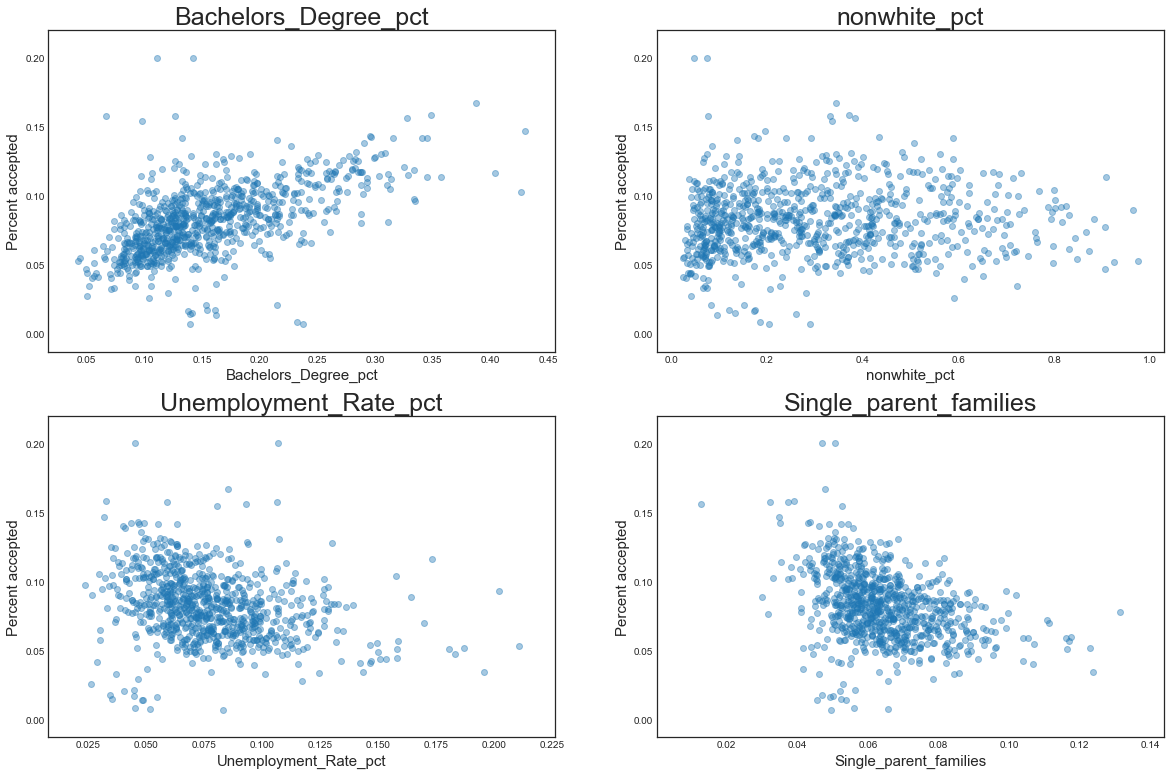

In [3]:
x_cols = ['Bachelors_Degree_pct','nonwhite_pct','Unemployment_Rate_pct', 'Single_parent_families']
fig = plt.figure(figsize=(20,13));
for i, col in enumerate(x_cols):
    ax = plt.subplot(2,2,i+1)
    ax.scatter(lc_census_merged14[col], lc_census_merged14['pct_accepted'], alpha=0.4)
    ax.set_ylabel('Percent accepted', fontsize=15)
    ax.set_xlabel(col, fontsize=15)
    ax.set_title(col, fontsize=25)
    
plt.show()

## 4.2 Assessing discrimination in our investment strategy

We now turn to our modeling efforts from before. It is important to note that our models have *already* made attempts at limiting discrimination by careful feature selection and oversampling defaulted loans to allow our model to be more sensitive to these important observations since a natural class imbalance exists in the raw data.

For the following analysis, we consider the loans we would recommend investing in using our ranked ROI from our logistic regression model. This model is among our top performers (as shown in the strategy curves previously shown), but, more importantly, using its predictions serve as an illustrative example since it still allows us to beat the market while still demonstrating discriminatory behavior that our investors may wish to consider in their portfolios.

Here we estimate two ordinary least squares models to make inferences about the relationship between different demographic characteristics and the Lending Club process as well as our own investment strategy.

(1)$$\ \widehat{(\%\ approved)}_{zip\ code} = \hat{\alpha} + \hat{\beta}_{education} + \hat{\beta}_{family\ status} + \hat{\beta}_{race} + \hat{\beta}_{unemployment}$$

(2)$$\ \widehat{(\%\ invested\ under\ loan\ strategy)}_{zip\ code} = \hat{\alpha} + \hat{\beta}_{education} + \hat{\beta}_{family\ status} + \hat{\beta}_{race} + \hat{\beta}_{unemployment}$$

Thus each $\hat{\beta}$ represents the relationship between the demographic composition of a region and (1) the percent of loans that are approved by Lending Club in that region or (2) the percent of loans that we recommend investing in within that region under our investment strategy. 

We can interpret the resulting coefficient estimates in (1) to be measures of differential group-level treatment in Lending Club's loan approval process while the coefficient estimates for model (2) can be viewed as measures of differential group-level treatment in our investment strategy.

The coefficient plots below, which show the estimate and the 95% confidence interval, are suggestive of a couple of things.

In the Lending Club loan approval process:
* loans are approved at a higher rate in areas with higher levels of education and also higher unemployment rates
* loans are approved at lower rates in areas with fewer single parent families
* racial demographics do not play a meaningful role in a region's loan approval rate

In our investment strategy:
* loans wind up in our investment portfolio at a higher rate in areas with higher unemployment rates and at a lower rate in areas with fewer single parent families
* education does not play a meaningful role in whether or not we suggest investing in a loan while race plays a mrginally more meaningful role, with loans from more nonwhite areas ending up in our suggested portfolio at a slightly higher rate

In [4]:
# function to do coef plot
def coef_plot(reg_obj, title, ax):
    err = reg_obj.params - reg_obj.conf_int()[0]
    coef = pd.DataFrame({'coef': reg_obj.params.values[1:],
                            'err': err.values[1:],
                            'varname': err.index.values[1:]
                           })

    coef.plot(x='varname', y='coef', kind='bar', 
                 ax=ax, color='none', 
                 yerr='err', legend=False)
    ax.set_ylabel(r'$\hat{\beta}$', fontsize=20)
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(coef.shape[0]), 
               marker='s', s=30, 
               y=coef['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    ax.xaxis.set_ticks_position('none')
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_title(title, fontsize=20)

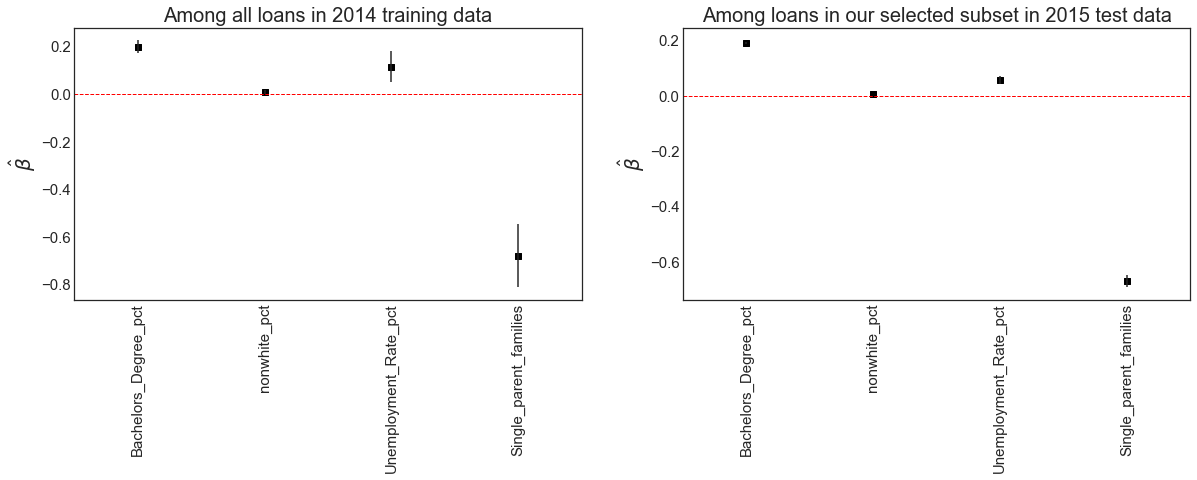

In [5]:
# OLS: pct_accepted ~ demographics for our all loans in training
X = lc_census_merged14[x_cols]
X = sm.add_constant(X)
pct_accepted_census_reg = OLS(lc_census_merged14['pct_accepted'], X, missing='drop').fit()

# OLS: pct_accepted ~ demographics for our selected loans in test
X = loans_bought15[x_cols]
X = sm.add_constant(X)
pct_accepted_census_reg_selected = OLS(loans_bought15['pct_accepted'], X, missing='drop').fit()

fig, ax = plt.subplots(1,2,figsize=(20,5))
coef_plot(pct_accepted_census_reg, 'Among all loans in 2014 training data', ax[0])
coef_plot(pct_accepted_census_reg_selected, 'Among loans in our selected subset in 2015 test data', ax[1])
plt.show()

Since the Census demographic data is continuous, it is difficult to label a protected class and a non-protected class to examine discriminatory behavior. We take a novel approach to discretize the characteristics of a loan applicant's geographic region on these dimensions that we have highlighted as relevant. We split each demographic group into quartiles: the first quartile captures zip codes with the highest concentration of the demographic and the fourth quartile captures zip codes with the lowest concentration of the demographic. 

We might find, for instance, that our modeling assigns lower default probability scores and suggests investing more money to the most educated areas while it assigns lower default probabilty scores and suggests investing less money in the least educated areas. We believe this is a fair way of examining discrimination and will easily allow us to remedy discrimination in our initial modeling and strategy.

Overall, we do not find that our model assigns different default probability scores to zip codes with different demographics, as shown in the kernel density estimates for our scores for the four quartiles on the four relevant demographic groups in both the training and test data. The one exception is education. It appears that the highest education bracket is assigned slightly lower default probability scores in both the training and test data. With this caveat, this is promising - perhaps our model with manual feature selection and oversampling is enough to reduce discrimination!

In [6]:
def plot_distr_quantiles(feature, score, title, xlabel, ax):
    tiles = np.percentile(feature.dropna(), [0,25,50,75,100])
    _0_25 = feature < tiles[1]
    _25_50 = (feature < tiles[2]) & (feature > tiles[1])
    _50_75 = (feature < tiles[3]) & (feature > tiles[2])
    _75_100 = (feature < tiles[4]) & (feature > tiles[3])

    sns.kdeplot(score[_0_25==True].dropna(), color="green", label="1st quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_25_50==True].dropna(), color="purple", label="2nd quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_50_75==True].dropna(), color="orange", label="3rd quartile", alpha=0.5, ax=ax)
    sns.kdeplot(score[_75_100==True].dropna(), color="blue", label="4th quartile", alpha=0.5, ax=ax)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=15)

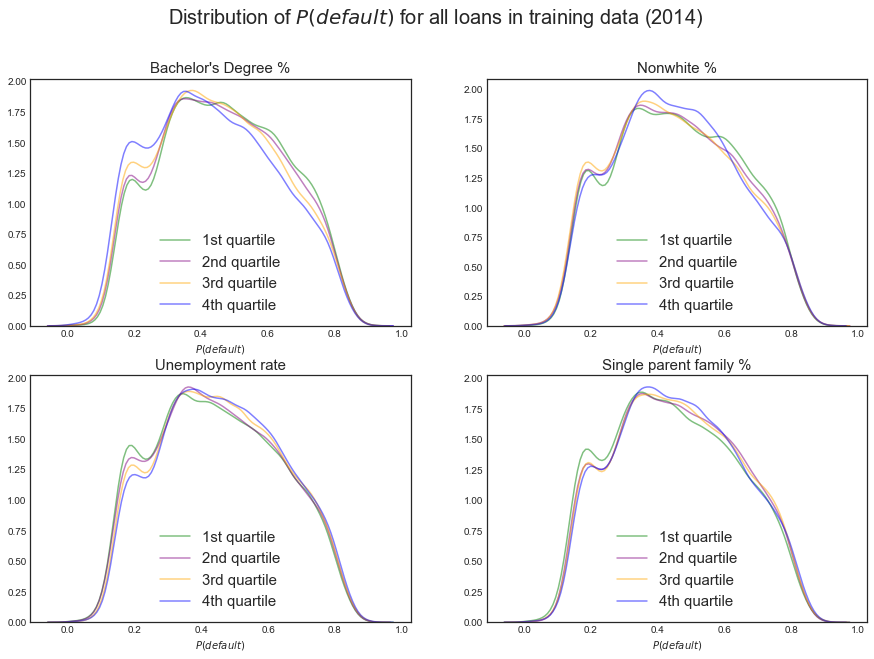

In [7]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2014_merged.Bachelors_Degree_pct, all_loans_2014_merged.proba, "Bachelor's Degree %", r"$P(default)$",ax[0,0])
plot_distr_quantiles(all_loans_2014_merged.nonwhite_pct, all_loans_2014_merged.proba, "Nonwhite %", r"$P(default)$",ax[0,1])
plot_distr_quantiles(all_loans_2014_merged.Unemployment_Rate_pct, all_loans_2014_merged.proba, "Unemployment rate", r"$P(default)$", ax[1,0])
plot_distr_quantiles(all_loans_2014_merged.Single_parent_families, all_loans_2014_merged.proba, "Single parent family %", r"$P(default)$", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in training data (2014)", fontsize=20)
plt.show()

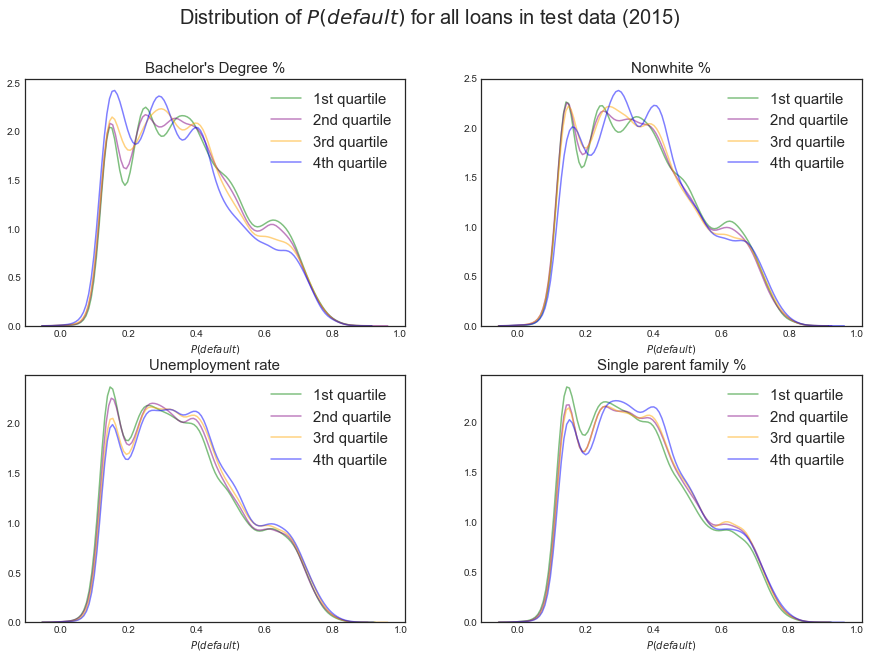

In [8]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
plot_distr_quantiles(all_loans_2015_merged.Bachelors_Degree_pct, all_loans_2015_merged.proba, "Bachelor's Degree %", r"$P(default)$", ax[0,0])
plot_distr_quantiles(all_loans_2015_merged.nonwhite_pct, all_loans_2015_merged.proba, "Nonwhite %", r"$P(default)$", ax[0,1])
plot_distr_quantiles(all_loans_2015_merged.Unemployment_Rate_pct, all_loans_2015_merged.proba, "Unemployment rate", r"$P(default)$", ax[1,0])
plot_distr_quantiles(all_loans_2015_merged.Single_parent_families, all_loans_2015_merged.proba, "Single parent family %", r"$P(default)$", ax[1,1])
plt.suptitle(r"Distribution of $P(default)$ for all loans in test data (2015)", fontsize=20)
plt.show()

Contrary evidence is presented in the two plots below. In the first plot, we fit a simple linear regression relating the number of loan applications Lending Club receives versus the percent of applications it approves in each zip code. The second plot does the same thing for the relationship between the percent of loans the Lending Club approves versus the percent of loans we recommend investing in for each zip code.

We see that Lending Club tends to approve slightly more loans in areas that submit more applications, although the trend is barely noticeable. On the other hand, there is a more discernible relationship between the rate at which Lending Club approves loans by zip code and the rate at which we recommend investing in loans by zip code. This is suggestive of our strategy adding in the differential treatment that was not present in Lending Club before the loans even get to investors.

Note that the loans that we would recommend investing in are determined by considering the case where an investor is looking to invest 200 million dollars into Lending Club loans. This is less than a half of one percent of Lending Club's 5.1 billion dollars in loans they granted in 2015.

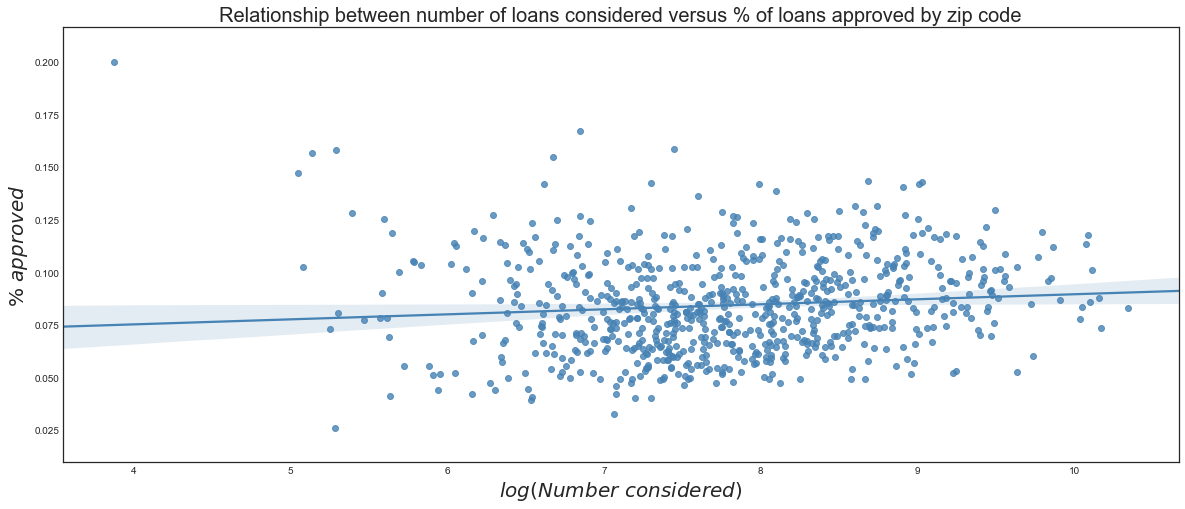

In [9]:
plt.figure(figsize=(20,8))
sns.regplot(np.log(loans_approved_invested14.num_loan_apps_considered), loans_approved_invested14.pct_accepted, 
            color="steelblue")
plt.xlabel(r'$log(Number\ considered)$', fontsize=20)
plt.ylabel(r'$\%\ approved$', fontsize=20)
plt.title('Relationship between number of loans considered versus % of loans approved by zip code', fontsize=20)
plt.show()

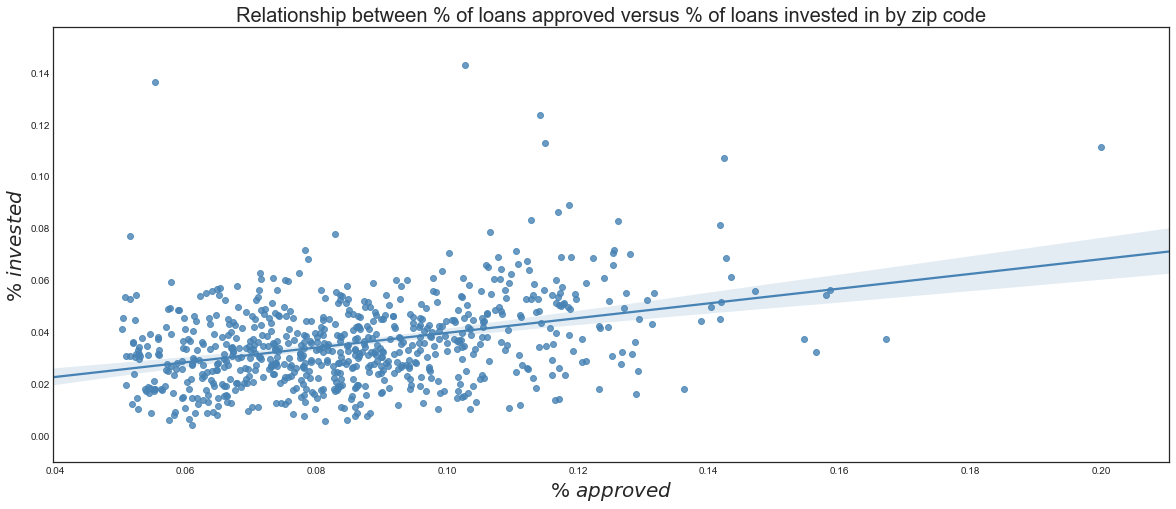

In [10]:
plt.figure(figsize=(20,8))
sns.regplot(loans_approved_invested14.pct_accepted[loans_approved_invested14.pct_accepted > 0.05], 
            loans_approved_invested14.pct_invested[loans_approved_invested14.pct_accepted > 0.05], color="steelblue")
plt.xlabel(r'$\%\ approved$', fontsize=20)
plt.ylabel(r'$\%\ invested$', fontsize=20)
plt.title('Relationship between % of loans approved versus % of loans invested in by zip code', fontsize=20)
plt.show()

## 4.3 Adjusting for statistical parity

The story gets more clear once we examine a more relevant features of our investment strategy: how much money we actually suggest investing in zip codes with different demographics makeups. This is easier to understand once we use a case study. 

Keeping with the precedence from above, let's say you are an investor in 2015 looking to invest in 200 million dollars in Lending Club loans. This is a hefty chunk of cash and you are worried that naively lending your money to maximize your profit will lead to you withholding money from groups that are systematically disadvantaged. Conveniently for us, you care about education, unemployment, race, and family status. You'd rather take a small hit in your return if you can invest your money evenly across people with demographic backgrounds.

With this in mind, we can use our current work to produce a **statistical parity adjustment** for your investment strategy. 
> "Statistical parity means that an equal proportion of defendants are detained in each race group... For example, white and black defendants are detained at equal rates. Formally, statistical parity means, $E[d(X) | g(X)]=E[d(X)]$" where $d(x)$ is the probability that the positive outcome is assigned to an individual with attributes $x$ while $g(x)$ indicates an individual's group membership ([Corbett-Davies et al., 2017](https://arxiv.org/abs/1701.08230)).

The results we find are quite encouraging. Compared to the baseline investment strategy, which produces a return on investment of 4.92%, we find that performing a statistical parity adjustment on any of these four demographic characteristics produces a return on investment that is only slightly lower than the optimal strategy while **significantly** balancing the amount of money we funnel into any demographic quartile.

The tables below show the amount of money our initial strategy recommends investing into each bracket of each demographic group, the amount of money our adjusted strategy recommends investing, and the return on investment for that bracket after the adjustment. At the bottom of the table is the overall adjusted return on investment for that demographic.

Before the adjustment, we invest 20 million more dollars into the highest educated areas than we do into the lowest educated areas. Similarly, we invest 16 million more dollars into the areas with the lowest levels of unemployment than we do into the areas with the highest unemployment and nearly 17 million more dollars into areas with the fewest proportion of single parent families as compared to the areas with the largest proportion of single parent families. 

These findings are, frankly, astounding.

But with our adjustment we can ensure that we invest the same amount of money into each bracket, as shown by the second column of each table. Notably, our return on investment does not change too much, dipping to 4.77% in the education case. Once we consider the initial 200 million dollar investment, this translates to a difference of just 30,000 dollars. 

Consdering this essentially negligible tradeoff, we would be happy to offer this socially conscious investing option to an investor.

In [11]:
# Statistical parity
def statistical_parity_measures(full_data, subset_data, protected, investment):
    # quartiles
    tiles = np.percentile(protected.dropna(), [0,25,50,75,100])
    _0_25 = protected <= tiles[1]
    _25_50 = (protected <= tiles[2]) & (protected > tiles[1])
    _50_75 = (protected <= tiles[3]) & (protected > tiles[2])
    _75_100 = (protected <= tiles[4]) & (protected > tiles[3])
    
    # calculate money invested in from all loans per quartile in initial strategy
    amnt_recommend_invest_before = [np.sum(subset_data.amnt[_0_25]), np.sum(subset_data.amnt[_25_50]),
                                    np.sum(subset_data.amnt[_50_75]), np.sum(subset_data.amnt[_75_100])]
    
    # calculate money invested in each quartile after adjustment
    ranked025 = full_data[_0_25]
    ranked2550 = full_data[_25_50]
    ranked5075 = full_data[_50_75]
    ranked75100 = full_data[_75_100]
    ranked025.loc[_0_25, 'cumsum_amnt'] = ranked025.loc[_0_25,'amnt'].cumsum()
    ranked2550.loc[_25_50, 'cumsum_amnt'] = ranked2550.loc[_25_50,'amnt'].cumsum()
    ranked5075.loc[_50_75, 'cumsum_amnt'] = ranked5075.loc[_50_75,'amnt'].cumsum()
    ranked75100.loc[_75_100, 'cumsum_amnt'] = ranked75100.loc[_75_100,'amnt'].cumsum()

    _0_25_underQuarterInvestment = ranked025.cumsum_amnt <= investment/4
    _25_50_underQuarterInvestment = ranked2550.cumsum_amnt <= investment/4
    _50_75_underQuarterInvestment = ranked5075.cumsum_amnt <= investment/4
    _75_100_underQuarterInvestment = ranked75100.cumsum_amnt <= investment/4                         
    
    amnt_recommend_invest_after = [np.sum(ranked025.amnt[_0_25_underQuarterInvestment]), 
                                   np.sum(ranked2550.amnt[_25_50_underQuarterInvestment]), 
                                   np.sum(ranked5075.amnt[_50_75_underQuarterInvestment]), 
                                   np.sum(ranked75100.amnt[_75_100_underQuarterInvestment])]
    
    # calculate return for the loans selected from each quartile 
    annualized_return_quartile = [np.sum(ranked025.Real_ROI[_0_25_underQuarterInvestment])/np.sum(ranked025.amnt[_0_25_underQuarterInvestment]),
                                  np.sum(ranked2550.Real_ROI[_25_50_underQuarterInvestment])/np.sum(ranked2550.amnt[_25_50_underQuarterInvestment]),
                                  np.sum(ranked5075.Real_ROI[_50_75_underQuarterInvestment])/np.sum(ranked5075.amnt[_50_75_underQuarterInvestment]),
                                  np.sum(ranked75100.Real_ROI[_75_100_underQuarterInvestment])/np.sum(ranked75100.amnt[_75_100_underQuarterInvestment])]

    # calculate overall return from this stategy
    # weight by number of loans
    num_loans_from_quartile = [np.sum(_0_25_underQuarterInvestment), np.sum(_25_50_underQuarterInvestment), 
                               np.sum(_50_75_underQuarterInvestment), np.sum(_75_100_underQuarterInvestment)]  
    overall_return = np.average(annualized_return_quartile, weights=num_loans_from_quartile)
    
    return amnt_recommend_invest_before, amnt_recommend_invest_after, annualized_return_quartile, overall_return


In [12]:
# Recall baseline performance
print("Recall how our initial investment strategy performed")
print("====================================================")
print('Return on investment if we took all 2015 loans:', round(np.sum(all_loans_2015_merged.Real_ROI)/np.sum(all_loans_2015_merged.amnt), 4))
res15 = all_loans_2015_merged
res15.loc[:, 'cumsum_amnt'] = res15.loc[:,'amnt'].cumsum()
ind_to_use = res15.cumsum_amnt <= 200000000
print('Return on investment if we took our recommend subset of loans:', round(np.sum(res15.Real_ROI[ind_to_use])/np.sum(res15.amnt[ind_to_use]), 4))

Recall how our initial investment strategy performed
Return on investment if we took all 2015 loans: 0.0325
Return on investment if we took our recommend subset of loans: 0.0492


In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
protected_features = ['Bachelors_Degree_pct','nonwhite_pct','Unemployment_Rate_pct','Single_parent_families']
for feature in protected_features:
    
    arib, aria, arq, ovret = statistical_parity_measures(all_loans_2015_merged, loans_bought15, all_loans_2015_merged[feature], 200000000)
    
    print('\n',feature)
    display(pd.DataFrame(np.concatenate([np.array(arib).reshape(-1,1), np.array(aria).reshape(-1,1), 
                                 np.array(arq).reshape(-1,1)], axis=1),
                columns=['Amount invested before adjustment', 'Amount invested after adjustment', 'Return after adjustment'],
                index=['1st quartile','2nd quartile','3rd quartile','4th quartile']))
    print('Return on investment after statistical parity adjustment for ', feature, ': ', round(ovret, 4), sep='')


 Bachelors_Degree_pct


,Amount invested before adjustment,Amount invested after adjustment,Return after adjustment
1st quartile,40743175.000,49982875.000,0.040
2nd quartile,47339075.000,49997575.000,0.047
3rd quartile,49610475.000,49995800.000,0.051
4th quartile,62248500.000,49998625.000,0.054


Return on investment after statistical parity adjustment for Bachelors_Degree_pct: 0.0477

 nonwhite_pct


,Amount invested before adjustment,Amount invested after adjustment,Return after adjustment
1st quartile,45160700.000,49991500.000,0.047
2nd quartile,54032575.000,49974225.000,0.048
3rd quartile,53842550.000,49985750.000,0.049
4th quartile,46905400.000,49995725.000,0.052


Return on investment after statistical parity adjustment for nonwhite_pct: 0.0491

 Unemployment_Rate_pct


,Amount invested before adjustment,Amount invested after adjustment,Return after adjustment
1st quartile,58075850.000,49980400.000,0.053
2nd quartile,53872850.000,49991750.000,0.049
3rd quartile,46060475.000,49991325.000,0.047
4th quartile,41932050.000,49972650.000,0.045


Return on investment after statistical parity adjustment for Unemployment_Rate_pct: 0.0487

 Single_parent_families


,Amount invested before adjustment,Amount invested after adjustment,Return after adjustment
1st quartile,59937700.000,49988950.000,0.055
2nd quartile,49879150.000,49998350.000,0.048
3rd quartile,47129325.000,49965975.000,0.048
4th quartile,42995050.000,49989500.000,0.043


Return on investment after statistical parity adjustment for Single_parent_families: 0.0483


## 4.4 Other approaches

Other similar adjustments could be made for **conditional parity** (statistical parity conditional on some legitimate risk factor) or **predictive equality** (equal false positive rates across groups) ([Corbett-Davies et al., 2017](https://arxiv.org/abs/1701.08230)). 

Another useful approach might be to employ a tool like a local surrogate model (such as LIME) to investigate the behavior of our model around the decision boundary and get a sense of what features play a role in assigning an observation to the positive or negative outcome ([Ribeiro, M.T., Singh, S. and Guestrin, C., 2016](https://arxiv.org/abs/1602.04938)). We could also do this through a tool like Quantitative Input Influence (QII), which uses causal inference techniques to examine the marginal influence of features on predictions ([Datta et al, IEEE S&P 2016](https://ieeexplore.ieee.org/document/7546525)).

Instead of making post-modeling adjustments, we could also bake a notion of group-level equity into our model's loss function. This can be done through packages such as [`themis-ml`](https://themis-ml.readthedocs.io/en/latest/) or IBM's [`AIF360`](https://github.com/IBM/AIF360), which capture a host of methods used for bias mitigation at the time of model building.

We do not claim that statistical parity is the best approach to use in this case. We acknowledge that focusing on this one notion of fairness can lead to unintended discrimination at the individual level ([Dwork et al., 2011](https://arxiv.org/abs/1104.3913)). We hoped to implement a model from either `themis-ml` or `AIF360` but simply ran out of time. 

We do argue that our approach of manually addressing discrimination rather than allowing another algorithm to address it left us with a full understanding of what this type of adjustment looks like and what kind of tradeoffs exist between fairness and maximizing an objective (here, return on investment). We are satisified with the complexity and encouraged that fairness constraints can be implemented in Lending Club more thoroughly without hurting investors incentives.